In this example we removed the additional state variables and thus constraints for state continuity between intervals. It seems, however that the solution is still unexpectrdly jumpy. The new hypothisis is that it is simply trying to minimize control effort and the time steps are the closest near the intersection of the intervals. It is also not trying to minimize time. Also, this is likely an artifact of this method.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.1, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1538
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      155
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa


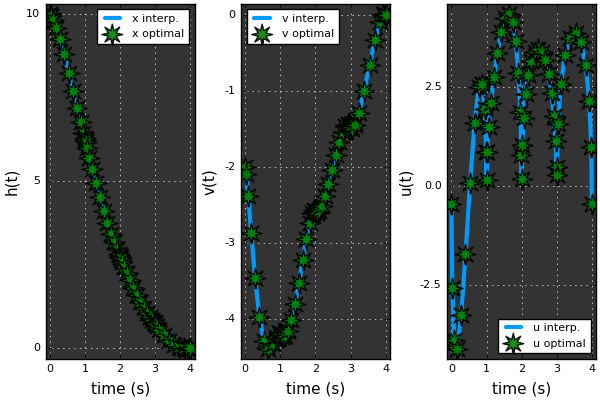

/home/febbo/.julia/v0.5/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [1]:
using NLOptControl
using JuMP
using Ipopt
using Parameters
using Plots
#using VehicleModels
pyplot()

##################################
# Define NLOptControl problem
##################################

# Moon Lander Problem
# http://www.gpops2.com/Examples/MoonLander.html
const g = 1.62519; # m/s^2
# define dynamic constraint equations
function stateEquations(x_int::Array{Any,2},u_int::Array{Any,2},st::Int64)
  if st==1
    return x_int[1:end-1,2]      # state eq# 1; v(t)
  elseif st==2
    return u_int[:,1] - g        # state eq# 2; u(t)-g
  end
end

X0=[10.0,-2.0]; XF=[0.,0.]    # TODO allow for int inputs and just convert them to Float64
XL=[-Inf,-Inf]; XU=[Inf,Inf]; # TODO allow for functions of these so we can calculate them on the fly!
CL=[-Inf]; CU=[Inf];
ps, nlp = initialize_NLP(numStates=2,
                         numControls=1,
                         Ni=4,Nck=[12,14,15,10],
                         stateEquations=stateEquations,
                         X0=X0,XF=XF,XL=XL,XU=XU,CL=CL,CU=CU);

# NOT GIVEN TIME INTERVAL-->fake it for now
# given time interval--> not always given though; might be a design variable (especially for optimal control problems)
t0 = Float64(0); tf = Float64(4); @pack ps = t0, tf;

# give the time interval we can calculate these ps parameters
@unpack Nck, Ni, t0, tf, τ, ω = ps;
di, tm, ts, ωₛ = create_intervals(t0,tf,Ni,Nck,τ,ω);
@pack ps = τ, ω, ωₛ, ts;

##################################
# Define JuMP problem
##################################

# initialize design problem
mdl = Model(solver = IpoptSolver());

x,u = OCPdef(mdl,nlp,ps)

obj = integrate(mdl,ps,u[:,1];(:variable=>:control))

@NLobjective(mdl, Min, obj)

obj_val = solve(mdl)

##################################
# Post Processing
##################################
lw=8; lw2=3;
#_st = [idx for tempM in ts for idx = tempM];
t_ctr= [idx for tempM in ts for idx = tempM[1:end-1]];
t_st = append!(t_ctr,ts[end][end]);

p1=plot(t_st,getvalue(x[:,1]), label = "x interp.",w=lw2)
scatter!(t_st,getvalue(x[:,1]), label = "x optimal",marker = (:star8, 15, 0.9, :green))
ylabel!("h(t)")
xlabel!("time (s)")

p2=plot(t_st,getvalue(x[:,2]), label = "v interp.",w=lw2)
scatter!(t_st,getvalue(x[:,2]), label = "v optimal",marker = (:star8, 15, 0.9, :green))
ylabel!("v(t)")
xlabel!("time (s)")

p3=plot(t_ctr,getvalue(u[:,1]), label = "u interp.",w=lw2)
scatter!(t_ctr,getvalue(u[:,1]), label = "u optimal",marker = (:star8, 15, 0.9, :green))
ylabel!("u(t)")
xlabel!("time (s)")

plot(p1,p2,p3,layout=(1,3),background_color_subplot=RGB(0.2,0.2,0.2), background_color_legend=RGB(1,1,1))
plot!(foreground_color_grid=RGB(1,1,1))